# 📘 Multimodal Deep Neural Network for YouTube Clickability

In this notebook we build and train **two multimodal deep neural networks** using the deep feature datasets from `D1_feature_engineering_deep.ipynb`:

- **Structured deep features** → `youtube_features_structured_deep.parquet`  *(shape: 5742 × 13)*  
- **Text deep features**       → `youtube_features_text_deep.parquet`      *(shape: 5742 × 768)*  
- **Image deep features**      → `youtube_features_image_deep.parquet`     *(shape: 5742 × 512)*  

🎯 **Targets**

- **Regression**: `youtube_target_regression.parquet`  
  - `views_per_subscriber` (clipped), shape `(5742, 1)`  
- **Classification**: `youtube_target_classification.parquet`  
  - `high_clickability` (top 25% = 1, else 0), shape `(5742, 1)`

We train **two separate models**:

1. 🔵 **Classification model**  
   - Task: predict `high_clickability` (0 / 1)  
   - Metrics: AUC, Accuracy, F1, Precision, Recall  

2. 🟢 **Regression model**  
   - Task: predict `views_per_subscriber` (continuous)  
   - Metrics: RMSE, MAE, R²  

All models use:

- Separate subnetworks for **structured / text / image**  
- **LeakyReLU** activations  
- **Dropout** + **weight decay** to reduce overfitting  
- A **moderate number of epochs** (not too big) so training converges but doesn’t explode.


In [1]:
# 0️⃣ 📦 Dependencies & Basic Imports

%pip install --quiet torch torchvision torchaudio scikit-learn pandas pyarrow matplotlib

import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


# 1️⃣ 📂 Paths, Device, and Load Deep Feature Datasets

We now:

1. Resolve the **processed data path**  
2. Load the **three deep feature matrices**  
3. Load the **two target files**  
4. Check shapes to be sure everything lines up

In [2]:
# 1️⃣ Paths, device, and data loading

# Paths
base = Path.cwd().parent
processed_path = base / "data" / "processed"

# Load feature matrices
X_struct = pd.read_parquet(processed_path / "youtube_features_structured_deep.parquet")
X_text   = pd.read_parquet(processed_path / "youtube_features_text_deep.parquet")
X_image  = pd.read_parquet(processed_path / "youtube_features_image_deep.parquet")

# Load targets
y_reg_df = pd.read_parquet(processed_path / "youtube_target_regression.parquet")
y_clf_df = pd.read_parquet(processed_path / "youtube_target_classification.parquet")

y_reg = y_reg_df.iloc[:, 0].values.astype(np.float32)  # (N,)
y_clf = y_clf_df.iloc[:, 0].values.astype(np.float32)  # (N,)

print("Structured deep →", X_struct.shape)
print("Text deep       →", X_text.shape)
print("Image deep      →", X_image.shape)
print("Regression y    →", y_reg.shape)
print("Classification y→", y_clf.shape)

assert X_struct.shape[0] == X_text.shape[0] == X_image.shape[0] == y_reg.shape[0] == y_clf.shape[0]
N = X_struct.shape[0]

# Device selection
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_text = "cuda"
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
    device_text = "mps"
else:
    device = torch.device("cpu")
    device_text = "cpu"

print("🖥 Using device:", device_text)

Structured deep → (5742, 13)
Text deep       → (5742, 128)
Image deep      → (5742, 128)
Regression y    → (5742,)
Classification y→ (5742,)
🖥 Using device: mps


# 2️⃣ 🔧 Preprocessing & Train/Val/Test Split

We:

- Standardize **structured deep features** with `StandardScaler`
- Leave text & image embeddings as they are (already deep embeddings)
- Use **stratified splits** based on the classification target:
  - 70% train
  - 15% validation
  - 15% test
- Build a unified **PyTorch Dataset** which returns:
  - structured features
  - text features
  - image features
  - classification label
  - regression target

In [3]:
# 2️⃣ Preprocessing & splits

from torch.utils.data import Dataset, DataLoader

# ---- Standardize structured features only ----
scaler_struct = StandardScaler()
X_struct_scaled = scaler_struct.fit_transform(X_struct.values.astype(np.float32))

X_text_np  = X_text.values.astype(np.float32)
X_image_np = X_image.values.astype(np.float32)


# ---- Train/val/test split (stratified on y_clf) ----
indices = np.arange(N)

train_idx, temp_idx, y_clf_train, y_clf_temp = train_test_split(
    indices,
    y_clf,
    test_size=0.30,
    stratify=y_clf,
    random_state=42,
)

val_idx, test_idx, y_clf_val, y_clf_test = train_test_split(
    temp_idx,
    y_clf_temp,
    test_size=0.50,
    stratify=y_clf_temp,
    random_state=42,
)

def slice_arrays(idxs):
    return (
        X_struct_scaled[idxs],
        X_text_np[idxs],
        X_image_np[idxs],
        y_clf[idxs],
        y_reg[idxs],
    )

X_struct_tr, X_text_tr, X_image_tr, y_clf_tr, y_reg_tr = slice_arrays(train_idx)
X_struct_va, X_text_va, X_image_va, y_clf_va, y_reg_va = slice_arrays(val_idx)
X_struct_te, X_text_te, X_image_te, y_clf_te, y_reg_te = slice_arrays(test_idx)

print("Train size:", len(train_idx))
print("Val size:  ", len(val_idx))
print("Test size: ", len(test_idx))


# ---- Dataset definition ----
class YTDeepDataset(Dataset):
    def __init__(self, Xs, Xt, Xi, yc, yr):
        self.Xs = torch.from_numpy(Xs).float()
        self.Xt = torch.from_numpy(Xt).float()
        self.Xi = torch.from_numpy(Xi).float()
        self.yc = torch.from_numpy(yc).float()  # classification
        self.yr = torch.from_numpy(yr).float()  # regression

    def __len__(self):
        return self.Xs.shape[0]

    def __getitem__(self, idx):
        return (
            self.Xs[idx],
            self.Xt[idx],
            self.Xi[idx],
            self.yc[idx],
            self.yr[idx],
        )

train_dataset = YTDeepDataset(X_struct_tr, X_text_tr, X_image_tr, y_clf_tr, y_reg_tr)
val_dataset   = YTDeepDataset(X_struct_va, X_text_va, X_image_va, y_clf_va, y_reg_va)
test_dataset  = YTDeepDataset(X_struct_te, X_text_te, X_image_te, y_clf_te, y_reg_te)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("✅ DataLoaders ready.")

Train size: 4019
Val size:   861
Test size:  862
✅ DataLoaders ready.


# 3️⃣ 🧱 Multimodal Model Architecture (with LeakyReLU)

We define a **single multimodal architecture** that we will instantiate twice:

- Once for **classification**
- Once for **regression**

Architecture:

- **Structured branch**
  - Linear(13 → 64) → LeakyReLU → BatchNorm → Dropout
- **Text branch**
  - Linear(768 → 512) → LeakyReLU → BatchNorm → Dropout
- **Image branch**
  - Linear(512 → 512) → LeakyReLU → BatchNorm → Dropout
- **Fusion**
  - Concatenate [struct_out, text_out, image_out] → size 64 + 512 + 512 = 1088  
  - Linear(1088 → 512) → LeakyReLU → Dropout  
  - Linear(512 → 256) → LeakyReLU → Dropout  
  - Linear(256 → 1) (logit or scalar)

We use **LeakyReLU** everywhere to keep gradients flowing, plus moderate **dropout** and **weight decay** to fight overfitting.

In [4]:
# 3️⃣ MultiModalNet (LeakyReLU + High Dropout + Small Layers)

class MultiModalNet(nn.Module):
    def __init__(
        self,
        d_struct: int = 13,    
        d_text: int = 128,     
        d_img: int = 128,      
        hidden_struct: int = 32,
        hidden_text: int = 64,
        hidden_img: int = 64,
        fusion_h1: int = 96,
        fusion_h2: int = 48,
        dropout: float = 0.1
    ):
        super().__init__()

        self.act = nn.LeakyReLU(0.01, inplace=True)

        # -------- STRUCTURED --------
        self.struct = nn.Sequential(
            nn.Linear(d_struct, hidden_struct),
            nn.BatchNorm1d(hidden_struct),
            self.act,
            nn.Dropout(dropout),
        )

        # -------- TEXT (PCA-128) --------
        self.text = nn.Sequential(
            nn.Linear(d_text, hidden_text),
            nn.BatchNorm1d(hidden_text),
            self.act,
            nn.Dropout(dropout),
        )

        # -------- IMAGE (PCA-128) --------
        self.image = nn.Sequential(
            nn.Linear(d_img, hidden_img),
            nn.BatchNorm1d(hidden_img),
            self.act,
            nn.Dropout(dropout),
        )

        # -------- FUSION --------
        fusion_in = hidden_struct + hidden_text + hidden_img # 32 + 64 + 64 = 160

        self.fusion = nn.Sequential(
            nn.Linear(fusion_in, fusion_h1), # 160 → 96
            nn.BatchNorm1d(fusion_h1),
            self.act,
            nn.Dropout(dropout),

            nn.Linear(fusion_h1, fusion_h2), # 96 → 48
            nn.BatchNorm1d(fusion_h2),
            self.act,
            nn.Dropout(dropout),

            nn.Linear(fusion_h2, 1), # final logit or regression
        )

    def forward(self, x_s, x_t, x_i):
        hs = self.struct(x_s)
        ht = self.text(x_t)
        hi = self.image(x_i)

        h = torch.cat([hs, ht, hi], dim=1) # concat all branches
        return self.fusion(h).squeeze(1)


# 4️⃣ 🧪 Training Utilities (Classification & Regression)

We now define:

- A small `set_seed` helper for reproducibility  
- A generic `run_epoch` function that:
  - Handles **train / eval** modes
  - Supports both **classification** and **regression**
  - Computes the relevant metrics  
- Simple training loops with:
  - Adam optimizer
  - Weight decay
  - Early stopping based on **val AUC** (classification) and **val RMSE** (regression)

In [5]:
# ============================================================
# 4️⃣ 🧪 Training Utilities (Classification & Regression)
# ============================================================

import random
import numpy as np
import torch
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score,
    precision_score, recall_score,
    mean_squared_error, mean_absolute_error, r2_score
)

# ------------------------------------------------------------
# Reproducibility
# ------------------------------------------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


# ------------------------------------------------------------
# Generic Epoch Runner
# ------------------------------------------------------------
def run_epoch(
    model: torch.nn.Module,
    loader,
    optimizer=None,
    task: str = "clf",
    pos_weight: float = 1.0,
    device: torch.device = torch.device("cpu"),
):
    """
    Runs one epoch.
    task: "clf" or "reg"
    If optimizer is None → eval mode.
    """
    is_train = optimizer is not None
    model.train(is_train)

    all_losses = []
    all_y_true = []
    all_y_pred = []

    # Loss function
    if task == "clf":
        pw = torch.tensor([pos_weight], dtype=torch.float32, device=device)
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pw)
    else:
        criterion = torch.nn.MSELoss()

    # Loop through batches
    for batch in loader:
        x_s, x_t, x_i, y_c, y_r = batch
        x_s = x_s.to(device)
        x_t = x_t.to(device)
        x_i = x_i.to(device)

        # Choose target based on task
        y = y_c.to(device) if task == "clf" else y_r.to(device)

        # Clear grads
        if is_train:
            optimizer.zero_grad()

        # Forward pass
        outputs = model(x_s, x_t, x_i)

        # Compute loss
        loss = criterion(outputs, y)

        # Backprop
        if is_train:
            loss.backward()
            optimizer.step()

        all_losses.append(loss.item())

        # Store predictions
        outputs_np = outputs.detach().cpu().numpy()
        y_np = y.cpu().numpy()

        if task == "clf":
            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            all_y_pred.extend(probs.tolist())
            all_y_true.extend(y_np.tolist())
        else:
            all_y_pred.extend(outputs_np.tolist())
            all_y_true.extend(y_np.tolist())

    # ---------------------------
    # Compute final metrics
    # ---------------------------
    metrics = {"loss": float(np.mean(all_losses))}
    y_true = np.array(all_y_true)
    y_pred = np.array(all_y_pred)

    if task == "clf":
        # AUC can fail if all labels are identical — catch it
        try:
            auc = roc_auc_score(y_true, y_pred)
        except ValueError:
            auc = np.nan

        y_hat = (y_pred >= 0.5).astype(int)

        metrics.update({
            "auc": auc,
            "acc": accuracy_score(y_true, y_hat),
            "f1": f1_score(y_true, y_hat, zero_division=0),
            "prec": precision_score(y_true, y_hat, zero_division=0),
            "rec": recall_score(y_true, y_hat, zero_division=0),
        })

    else:  # Regression
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)

        # R² may fail if constant target — guard it
        try:
            r2 = r2_score(y_true, y_pred)
        except ValueError:
            r2 = np.nan

        metrics.update({
            "rmse": rmse,
            "mae": mae,
            "r2": r2,
        })

    return metrics

# 5️⃣ 🎯 Train & Evaluate the Classification Model

Settings:

- Task: **high_clickability** (0 / 1)  
- Loss: `BCEWithLogitsLoss` with `pos_weight` for class imbalance  
- Optimizer: `Adam(lr=2e-3, weight_decay=1e-4)`  
- Epochs: **15** (good tradeoff between convergence and overfitting)  
- Early stopping based on **best validation AUC**  

We’ll:

1. Train for up to 15 epochs  
2. Track train loss and val metrics  
3. Keep a copy of the **best model state (highest val AUC)**  
4. Evaluate that best model on the **test set**

In [6]:
# -----------------------------------------------------------
# 5️⃣ Classification Training — True Logging + Early Stopping
# -----------------------------------------------------------

set_seed(42)

# classifier model
clf_model = MultiModalNet(d_struct=X_struct_tr.shape[1], d_text=X_text_tr.shape[1], d_img=X_image_tr.shape[1], dropout=0.6).to(device)

# Compute pos_weight (imbalanced dataset ~75% negatives)
pos_fraction = y_clf.mean()
neg_fraction = 1 - pos_fraction
pos_weight_value = neg_fraction / max(pos_fraction, 1e-6)
print(f"Estimated pos_weight = {pos_weight_value:.2f}")

criterion_clf = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value]).to(device))

clf_optimizer = torch.optim.Adam(
    clf_model.parameters(),
    lr=2e-3,
    weight_decay=1e-4,
)

EPOCHS_CLS = 15
best_val_auc = -np.inf
best_clf_state = None

# --- Logging history ---
clf_history = {
    "train_loss": [],
    "val_loss": [],
    "val_auc": [],
    "val_acc": [],
    "val_f1": [],
}

print("🔥 Starting classification training...\n")

for epoch in range(1, EPOCHS_CLS + 1):

    # -------- TRAIN --------
    train_metrics = run_epoch(
        clf_model,
        train_loader,
        optimizer=clf_optimizer,
        task="clf",
        pos_weight=pos_weight_value,
        device=device,
    )

    # -------- VALIDATION --------
    val_metrics = run_epoch(
        clf_model,
        val_loader,
        optimizer=None,
        task="clf",
        pos_weight=pos_weight_value,
        device=device,
    )

    # Save logs
    clf_history["train_loss"].append(train_metrics["loss"])
    clf_history["val_loss"].append(val_metrics["loss"])
    clf_history["val_auc"].append(val_metrics["auc"])
    clf_history["val_acc"].append(val_metrics["acc"])
    clf_history["val_f1"].append(val_metrics["f1"])

    # Print nicely
    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_metrics['loss']:.4f} | "
        f"Val Loss: {val_metrics['loss']:.4f} | "
        f"Val AUC: {val_metrics['auc']:.3f} | "
        f"Acc: {val_metrics['acc']:.3f} | "
        f"F1: {val_metrics['f1']:.3f}"
    )

    # Early stopping → best AUC
    if val_metrics["auc"] > best_val_auc:
        best_val_auc = val_metrics["auc"]
        best_clf_state = clf_model.state_dict().copy()

print(f"\n✅ Best Val AUC: {best_val_auc:.3f}")

# Restore best weights
clf_model.load_state_dict(best_clf_state)

# -------- TEST EVAL --------
test_metrics_clf = run_epoch(
    clf_model,
    test_loader,
    optimizer=None,
    task="clf",
    pos_weight=pos_weight_value,
    device=device,
)

print("\n📊 TEST RESULTS — Classification")
for k, v in test_metrics_clf.items():
    print(f"{k:>6}: {v:.4f}")

Estimated pos_weight = 3.00
🔥 Starting classification training...

Epoch 01 | Train Loss: 1.0611 | Val Loss: 0.9921 | Val AUC: 0.677 | Acc: 0.520 | F1: 0.450
Epoch 02 | Train Loss: 0.9962 | Val Loss: 0.9401 | Val AUC: 0.735 | Acc: 0.614 | F1: 0.507
Epoch 03 | Train Loss: 0.9407 | Val Loss: 0.8783 | Val AUC: 0.772 | Acc: 0.642 | F1: 0.528
Epoch 04 | Train Loss: 0.8989 | Val Loss: 0.8393 | Val AUC: 0.789 | Acc: 0.669 | F1: 0.541
Epoch 05 | Train Loss: 0.8622 | Val Loss: 0.8182 | Val AUC: 0.800 | Acc: 0.682 | F1: 0.552
Epoch 06 | Train Loss: 0.8272 | Val Loss: 0.8056 | Val AUC: 0.809 | Acc: 0.691 | F1: 0.564
Epoch 07 | Train Loss: 0.8146 | Val Loss: 0.7881 | Val AUC: 0.816 | Acc: 0.706 | F1: 0.570
Epoch 08 | Train Loss: 0.8072 | Val Loss: 0.7720 | Val AUC: 0.824 | Acc: 0.718 | F1: 0.586
Epoch 09 | Train Loss: 0.7882 | Val Loss: 0.7766 | Val AUC: 0.824 | Acc: 0.719 | F1: 0.591
Epoch 10 | Train Loss: 0.7812 | Val Loss: 0.7720 | Val AUC: 0.827 | Acc: 0.736 | F1: 0.607
Epoch 11 | Train Loss: 

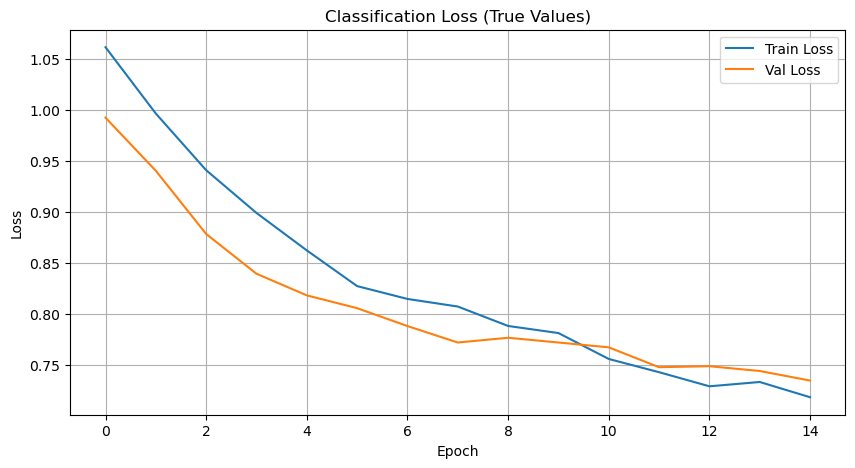

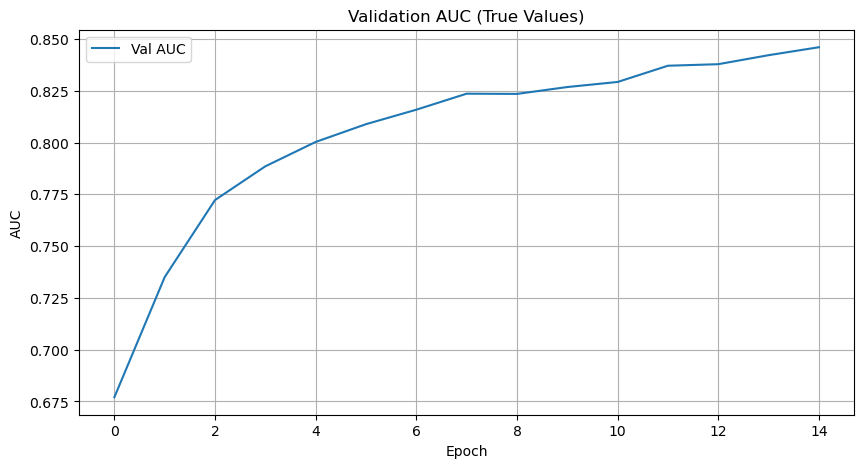

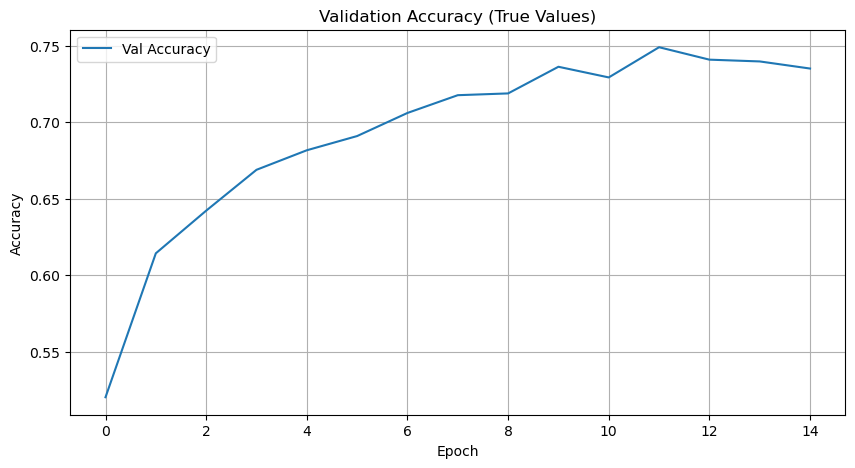

In [7]:
# -----------------------------------------------------------
# 5b. 📊 Plot True Training Curves
# -----------------------------------------------------------

import matplotlib.pyplot as plt

# ----- Loss curve -----
plt.figure(figsize=(10, 5))
plt.plot(clf_history["train_loss"], label="Train Loss")
plt.plot(clf_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classification Loss (True Values)")
plt.grid(True)
plt.legend()
plt.show()

# ----- AUC curve -----
plt.figure(figsize=(10, 5))
plt.plot(clf_history["val_auc"], label="Val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Validation AUC (True Values)")
plt.grid(True)
plt.legend()
plt.show()

# ----- Accuracy curve -----
plt.figure(figsize=(10, 5))
plt.plot(clf_history["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy (True Values)")
plt.grid(True)
plt.legend()
plt.show()

# 6️⃣ 📈 Train & Evaluate the Regression Model

Settings:

- Task: **views_per_subscriber** (continuous, clipped)  
- Loss: **MSELoss** (report RMSE, MAE, R²)  
- Optimizer: `Adam(lr=1e-3, weight_decay=1e-4)`  
- Epochs: **20** (slightly more, regression usually needs a bit longer)  
- Early stopping based on **best validation RMSE** (lower is better)

We reuse the **same train/val/test splits** as the classifier so results are comparable.

In [8]:
# 6️⃣ Regression training

set_seed(42)

reg_model = MultiModalNet(d_struct=X_struct_tr.shape[1], d_text=X_text_tr.shape[1], d_img=X_image_tr.shape[1], dropout=0.5).to(device)

reg_optimizer = torch.optim.Adam(
    reg_model.parameters(),
    lr=1e-3,
    weight_decay=1e-4,
)

EPOCHS_REG = 20
best_val_rmse = np.inf
best_reg_state = None

# ---- store training history ----
reg_train_rmse_hist = []
reg_val_rmse_hist   = []

print("\n🔥 Starting regression training...\n")

for epoch in range(1, EPOCHS_REG + 1):

    # TRAIN
    train_metrics = run_epoch(
        reg_model, train_loader,
        optimizer=reg_optimizer,
        task="reg", device=device
    )

    # VAL
    val_metrics = run_epoch(
        reg_model, val_loader,
        optimizer=None,
        task="reg", device=device
    )

    reg_train_rmse_hist.append(train_metrics["rmse"])
    reg_val_rmse_hist.append(val_metrics["rmse"])

    print(
        f"Epoch {epoch:02d} | "
        f"Train RMSE: {train_metrics['rmse']:.2f} | "
        f"Val RMSE: {val_metrics['rmse']:.2f} | "
        f"MAE: {val_metrics['mae']:.2f} | "
        f"R²: {val_metrics['r2']:.3f}"
    )

    # save best model
    if val_metrics["rmse"] < best_val_rmse:
        best_val_rmse = val_metrics["rmse"]
        best_reg_state = reg_model.state_dict().copy()

print(f"\n✅ Best Val RMSE: {best_val_rmse:.2f}")

# Load best weights
reg_model.load_state_dict(best_reg_state)

# ---- TEST ----
test_metrics_reg = run_epoch(
    reg_model, test_loader,
    optimizer=None, task="reg", device=device
)

print("\n📈 TEST RESULTS — Regression")
for k, v in test_metrics_reg.items():
    print(f"{k:>6}: {v:.4f}")


🔥 Starting regression training...

Epoch 01 | Train RMSE: 52.72 | Val RMSE: 43.40 | MAE: 7.69 | R²: -0.022
Epoch 02 | Train RMSE: 52.49 | Val RMSE: 43.14 | MAE: 7.98 | R²: -0.009
Epoch 03 | Train RMSE: 52.05 | Val RMSE: 42.65 | MAE: 8.53 | R²: 0.014
Epoch 04 | Train RMSE: 51.21 | Val RMSE: 42.11 | MAE: 8.98 | R²: 0.038
Epoch 05 | Train RMSE: 50.37 | Val RMSE: 41.58 | MAE: 9.35 | R²: 0.062
Epoch 06 | Train RMSE: 49.50 | Val RMSE: 41.33 | MAE: 9.99 | R²: 0.074
Epoch 07 | Train RMSE: 48.50 | Val RMSE: 40.96 | MAE: 10.15 | R²: 0.090
Epoch 08 | Train RMSE: 47.75 | Val RMSE: 40.92 | MAE: 10.77 | R²: 0.092
Epoch 09 | Train RMSE: 47.11 | Val RMSE: 41.04 | MAE: 10.51 | R²: 0.087
Epoch 10 | Train RMSE: 46.12 | Val RMSE: 40.81 | MAE: 9.94 | R²: 0.097
Epoch 11 | Train RMSE: 45.55 | Val RMSE: 41.06 | MAE: 10.04 | R²: 0.086
Epoch 12 | Train RMSE: 44.83 | Val RMSE: 41.16 | MAE: 10.09 | R²: 0.081
Epoch 13 | Train RMSE: 45.19 | Val RMSE: 41.07 | MAE: 9.92 | R²: 0.085
Epoch 14 | Train RMSE: 44.08 | Val

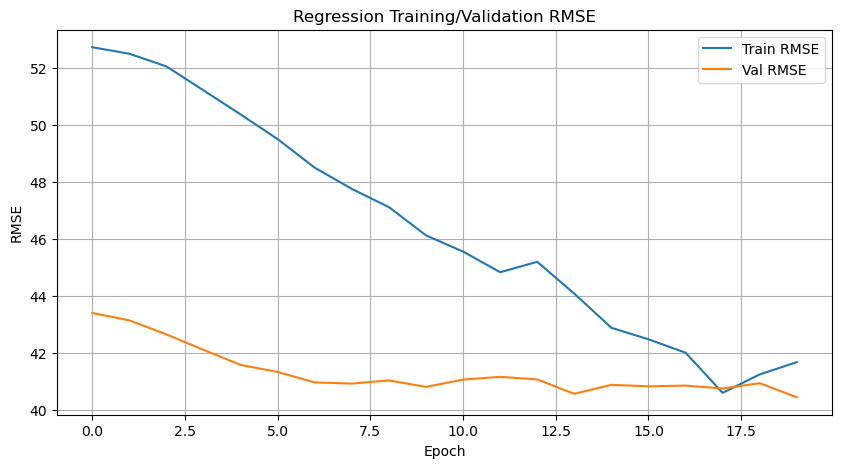

In [9]:
# ============================================================
# 📈 Visualization — Regression Training Curves
# ============================================================

plt.figure(figsize=(10,5))
plt.plot(reg_train_rmse_hist, label="Train RMSE")
plt.plot(reg_val_rmse_hist,   label="Val RMSE")
plt.title("Regression Training/Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.show()